In [4]:
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
NB_DIR = Path().resolve()
ROOT = NB_DIR.parent
print(ROOT)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SCALE = 0.75
DATA = "data/gutter_regressor/new"

DATA_PATH = Path(ROOT / DATA)
print(DATA_PATH)

C:\Users\jleto\Projects\rev-vision
C:\Users\jleto\Projects\rev-vision\data\gutter_regressor\new


In [2]:
def draw_line_heatmap(h, w, points, thickness=2):
    heatmap = np.zeros((h, w), dtype=np.float32)
    pts = np.array(points, dtype=np.int32)

    for i in range(len(pts) - 1):
        cv2.line(
            heatmap,
            tuple(pts[i]),
            tuple(pts[i + 1]),
            color=1.0,
            thickness=thickness
        )

    heatmap = cv2.GaussianBlur(heatmap, (5, 5), 0)
    heatmap = np.clip(heatmap, 0, 1)
    return heatmap


In [3]:
class LaneLineDataset(Dataset):
    def __init__(self, DATA_PATH, scale=0.75):
        self.root = Path(DATA_PATH)
        self.scale = scale
        self.jsons = sorted(self.root.glob("*.json"))

    def __len__(self):
        return len(self.jsons)

    def __getitem__(self, idx):
        with open(self.jsons[idx]) as f:
            data = json.load(f)

        img_path = self.root / data["imagePath"]
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        h0, w0 = img.shape[:2]
        img = cv2.resize(img, (int(w0 * self.scale), int(h0 * self.scale)))
        h, w = img.shape[:2]

        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))  # CHW

        target = np.zeros((2, h, w), dtype=np.float32)

        for shape in data["shapes"]:
            pts = np.array(shape["points"], dtype=np.float32)
            pts *= self.scale

            if shape["label"] == "left":
                target[0] = draw_line_heatmap(h, w, pts)
            elif shape["label"] == "right":
                target[1] = draw_line_heatmap(h, w, pts)

        return torch.from_numpy(img), torch.from_numpy(target)


In [6]:
class LaneHeatmapNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 2, 1)  # 2 heatmaps: left, right
        )

    def forward(self, x):
        return self.net(x)


In [7]:
ds = LaneLineDataset(DATA_PATH, scale=SCALE)
loader = DataLoader(ds, batch_size=4, shuffle=True)

model = LaneHeatmapNet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [8]:
EPOCHS = 30

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    for img, target in loader:
        img = img.to(device)
        target = target.to(device)

        pred = model(img)
        loss = criterion(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f}")

    # save every epoch so you never lose progress
    torch.save(model.state_dict(), "lane_heatmap_latest.pt")


Epoch 1/30 | Loss: 0.5810
Epoch 2/30 | Loss: 0.3798
Epoch 3/30 | Loss: 0.1253
Epoch 4/30 | Loss: 0.0233
Epoch 5/30 | Loss: 0.0106
Epoch 6/30 | Loss: 0.0121
Epoch 7/30 | Loss: 0.0148
Epoch 8/30 | Loss: 0.0163
Epoch 9/30 | Loss: 0.0177
Epoch 10/30 | Loss: 0.0173
Epoch 11/30 | Loss: 0.0168
Epoch 12/30 | Loss: 0.0156
Epoch 13/30 | Loss: 0.0149
Epoch 14/30 | Loss: 0.0138
Epoch 15/30 | Loss: 0.0135
Epoch 16/30 | Loss: 0.0121
Epoch 17/30 | Loss: 0.0111
Epoch 18/30 | Loss: 0.0100
Epoch 19/30 | Loss: 0.0105
Epoch 20/30 | Loss: 0.0094
Epoch 21/30 | Loss: 0.0100
Epoch 22/30 | Loss: 0.0090
Epoch 23/30 | Loss: 0.0089
Epoch 24/30 | Loss: 0.0094
Epoch 25/30 | Loss: 0.0090
Epoch 26/30 | Loss: 0.0086
Epoch 27/30 | Loss: 0.0090
Epoch 28/30 | Loss: 0.0094
Epoch 29/30 | Loss: 0.0082
Epoch 30/30 | Loss: 0.0081


C:\Users\jleto\AppData\Local\Temp\ipykernel_2440\1372790633.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lane_heatmap_latest.pt", ma

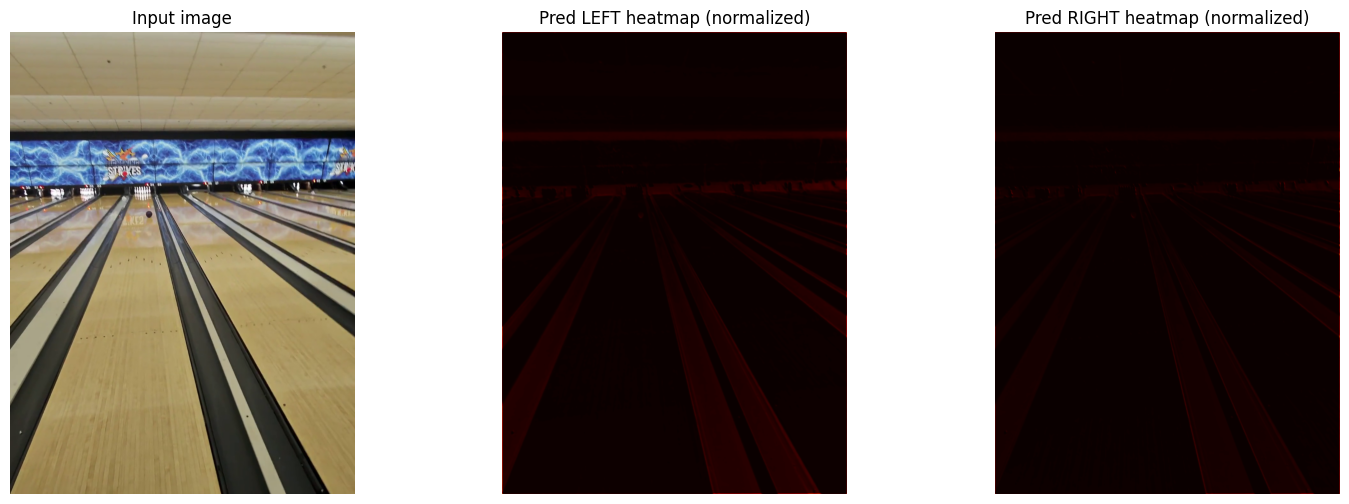

In [43]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- load model ---
model.load_state_dict(torch.load("lane_heatmap_latest.pt", map_location=device))
model.eval()

# --- pick random sample from dataset (image only) ---
i = random.randrange(len(ds))
img, _ = ds[i]   # IGNORE TARGET ON PURPOSE

with torch.no_grad():
    pred = torch.sigmoid(model(img.unsqueeze(0).to(device)))[0].cpu()

# --- image ---
img_np = img.permute(1, 2, 0).numpy()

# --- normalize heatmaps for visualization ONLY ---
left_hm  = pred[0].numpy()
right_hm = pred[1].numpy()

left_vis  = left_hm  / (left_hm.max()  + 1e-6)
right_vis = right_hm / (right_hm.max() + 1e-6)

# --- plot ---
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.title("Input image")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Pred LEFT heatmap (normalized)")
plt.imshow(left_vis, cmap="hot")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Pred RIGHT heatmap (normalized)")
plt.imshow(right_vis, cmap="hot")
plt.axis("off")

plt.show()
